In [1]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: edgeR

Loading required package: limma



In [2]:
source('milo_cellbender.R')

In [3]:
obj_neuron = qs::qread('_targets/objects/obj_neuron') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_neuron

An object of class Seurat 
29128 features across 104587 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



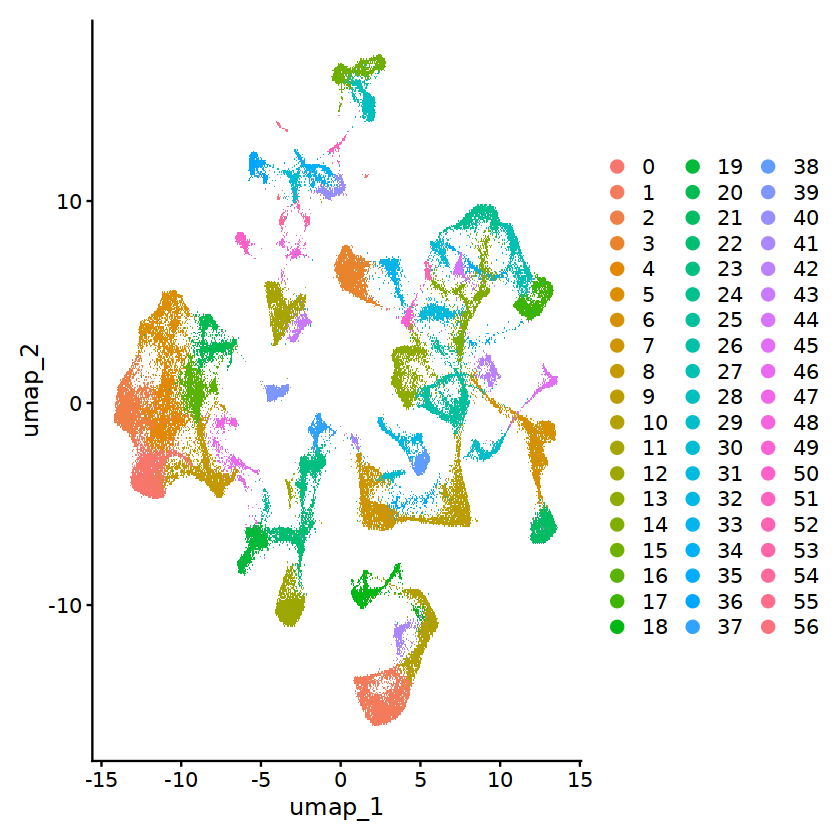

In [4]:
DimPlot(obj_neuron)

In [5]:
obj_other = qs::qread('_targets/objects/obj_other') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_other

An object of class Seurat 
25033 features across 29782 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

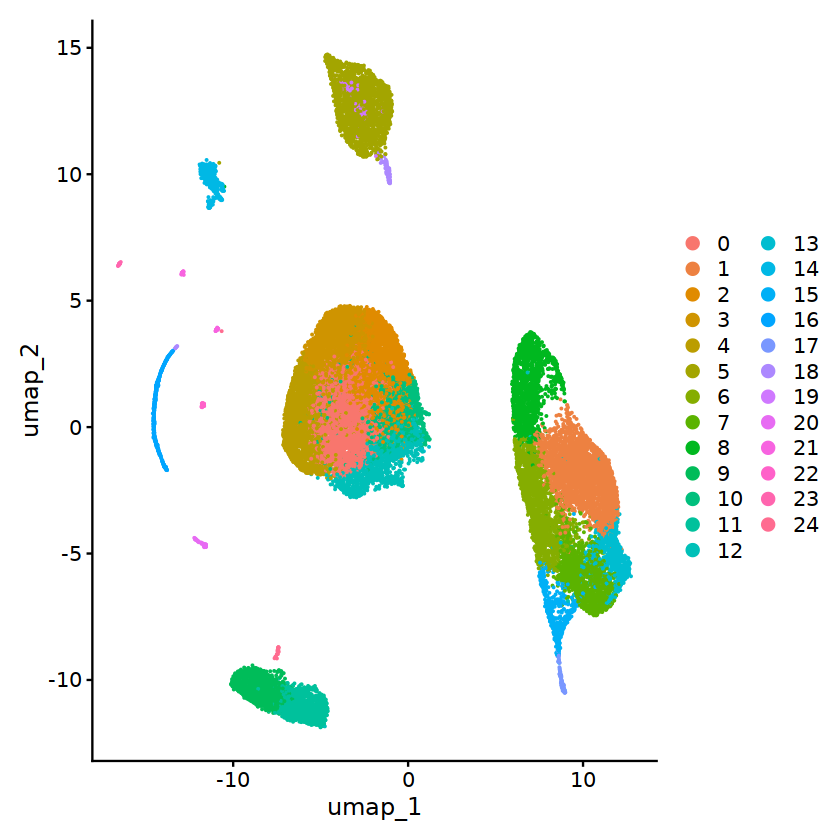

In [6]:
DimPlot(obj_other)

In [7]:
labels_classes_tib = (obj_other@meta.data %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% select(labels) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))


In [8]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,1.060039,-9.89935829
2,SI-TT-A11_AAACCCACATACAGCT,4.324369,1.16208909
3,SI-TT-A11_AAACCCACATGAGGGT,4.696438,-3.14927985
4,SI-TT-A11_AAACCCAGTACGTTCA,1.344125,-13.86531212
5,SI-TT-A11_AAACCCATCCAAGCAT,-5.445605,12.35118530
6,SI-TT-A11_AAACCCATCCCATAAG,-9.186716,0.09222025


In [9]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,9.741567,-6.3410525
2,SI-TT-A11_AAACGAAAGGTTCTTG,-8.439921,-10.6500720
3,SI-TT-A11_AAACGAACAAGGAGTC,-3.407435,-0.5645014
4,SI-TT-A11_AAACGAACAGCCTTCT,-4.795028,1.1611348
5,SI-TT-A11_AAACGCTAGTGCTAGG,12.090093,-5.6987538
6,SI-TT-A11_AAAGGATTCAACCCGG,8.568621,-2.9679698


In [10]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [11]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 134369      3

In [12]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob14v14__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob14v14__v__all.obobBL6')
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 26179    18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-2.320045141,12.19832,9.838683e+00,0.002213171,0.7414122,142,0.9234267,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,none,none,none,none,SI-TT-E12_AACCACACACAGTGAG,75
2,-1.798599545,12.39617,8.534432e+00,0.004487855,0.7517157,191,0.9234267,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F11_ATTACCTTCACTCCGT,93
3,0.002565596,12.11837,4.207191e-06,0.998367400,1.0000000,1,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-H10_GTCGTAAAGCCAGTAG,71
4,0.030158423,12.32363,1.516155e-03,0.969017914,1.0000000,2,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,none,none,none,none,SI-TT-H10_TGTCCCAGTTACAGCT,87
5,-0.646116135,12.40520,1.472211e+00,0.227777395,1.0000000,3,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F10_TGATCAGAGATGCCGA,109
6,-0.774713929,12.38027,2.120968e+00,0.148433252,1.0000000,4,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F10_CCTTCAGGTCAGGAGT,103


In [13]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC)


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,7.515957,12.97996,379.8192,1.207241e-33,4.044256e-31,42,1.966418e-31,pos,Agrp,1,112,SI-TT-F10_GATGTTGCATGTGACT
2,8.003707,12.95989,399.9349,3.060410e-33,5.126187e-31,220,3.332260e-31,pos,Agrp,1,111,SI-TT-G10_TTCTTCCCACGGTGTC
3,7.953393,12.92120,384.8309,1.130030e-32,1.261867e-30,97,7.442757e-31,pos,Agrp,1,107,SI-TT-G10_ACTTCGCGTCGGTACC
4,7.949918,12.94269,372.9086,3.266295e-32,2.735522e-30,164,1.527553e-30,pos,Agrp,1,108,SI-TT-E12_CTGCCTATCCCGAGGT
5,7.894118,12.88443,350.5554,2.582050e-31,1.729974e-29,168,9.649162e-30,pos,Agrp,1,104,SI-TT-F10_AGGTCTAAGGAATTAC
6,7.849137,12.80822,320.1283,5.153435e-30,2.877335e-28,278,1.725157e-28,pos,Agrp,1,98,SI-TT-G10_GCTCAAACAGGCTACC


In [14]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_all.obob14v14') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 26179    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,-2.320045141,12.19832,9.838683e+00,0.002213171,0.7414122,142,0.9234267,none,Agrp,1,75,SI-TT-E12_AACCACACACAGTGAG
2,-1.798599545,12.39617,8.534432e+00,0.004487855,0.7517157,191,0.9234267,none,Agrp,1,93,SI-TT-F11_ATTACCTTCACTCCGT
3,0.002565596,12.11837,4.207191e-06,0.998367400,1.0000000,1,1.0000000,none,Agrp,1,71,SI-TT-H10_GTCGTAAAGCCAGTAG
4,0.030158423,12.32363,1.516155e-03,0.969017914,1.0000000,2,1.0000000,none,Agrp,1,87,SI-TT-H10_TGTCCCAGTTACAGCT
5,-0.646116135,12.40520,1.472211e+00,0.227777395,1.0000000,3,1.0000000,none,Agrp,1,109,SI-TT-F10_TGATCAGAGATGCCGA
6,-0.774713929,12.38027,2.120968e+00,0.148433252,1.0000000,4,1.0000000,none,Agrp,1,103,SI-TT-F10_CCTTCAGGTCAGGAGT


In [15]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,-2.320045141,12.19832,9.838683e+00,0.002213171,0.7414122,142,0.9234267,none,Agrp,1,⋯,-0.5523687,12.19832,0.61969454,4.329205e-01,0.4532136911,0.4487377610,none,1,75,SI-TT-E12_AACCACACACAGTGAG
2,-1.798599545,12.39617,8.534432e+00,0.004487855,0.7517157,191,0.9234267,none,Agrp,1,⋯,-4.8926816,12.39617,13.18380221,4.874666e-04,0.0009226062,0.0008153479,neg,1,93,SI-TT-F11_ATTACCTTCACTCCGT
3,0.002565596,12.11837,4.207191e-06,0.998367400,1.0000000,1,1.0000000,none,Agrp,1,⋯,-2.8895384,12.11837,6.54258420,1.199080e-02,0.0138514370,0.0133302287,neg,1,71,SI-TT-H10_GTCGTAAAGCCAGTAG
4,0.030158423,12.32363,1.516155e-03,0.969017914,1.0000000,2,1.0000000,none,Agrp,1,⋯,0.1322664,12.32363,0.02627504,8.715589e-01,0.8715589187,0.8715589187,none,1,87,SI-TT-H10_TGTCCCAGTTACAGCT
5,-0.646116135,12.40520,1.472211e+00,0.227777395,1.0000000,3,1.0000000,none,Agrp,1,⋯,-3.7486741,12.40520,14.72167516,2.153020e-04,0.0005264684,0.0004562408,neg,1,109,SI-TT-F10_TGATCAGAGATGCCGA
6,-0.774713929,12.38027,2.120968e+00,0.148433252,1.0000000,4,1.0000000,none,Agrp,1,⋯,-4.9242261,12.38027,17.61564510,5.873893e-05,0.0001967754,0.0001657802,neg,1,103,SI-TT-F10_CCTTCAGGTCAGGAGT


In [16]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 26179    39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,-2.320045141,12.19832,9.838683e+00,0.002213171,0.7414122,142,0.9234267,none,Agrp,1,⋯,0.61969454,4.329205e-01,0.4532136911,0.4487377610,none,1,75,neuron,1.749498,-15.74457
2,-1.798599545,12.39617,8.534432e+00,0.004487855,0.7517157,191,0.9234267,none,Agrp,1,⋯,13.18380221,4.874666e-04,0.0009226062,0.0008153479,neg,1,93,neuron,3.920698,-15.08390
3,0.002565596,12.11837,4.207191e-06,0.998367400,1.0000000,1,1.0000000,none,Agrp,1,⋯,6.54258420,1.199080e-02,0.0138514370,0.0133302287,neg,1,71,neuron,2.174257,-14.59240
4,0.030158423,12.32363,1.516155e-03,0.969017914,1.0000000,2,1.0000000,none,Agrp,1,⋯,0.02627504,8.715589e-01,0.8715589187,0.8715589187,none,1,87,neuron,4.259051,-13.95177
5,-0.646116135,12.40520,1.472211e+00,0.227777395,1.0000000,3,1.0000000,none,Agrp,1,⋯,14.72167516,2.153020e-04,0.0005264684,0.0004562408,neg,1,109,neuron,1.299426,-14.56250
6,-0.774713929,12.38027,2.120968e+00,0.148433252,1.0000000,4,1.0000000,none,Agrp,1,⋯,17.61564510,5.873893e-05,0.0001967754,0.0001657802,neg,1,103,neuron,1.450076,-14.22874


In [17]:
da_results_restored 

logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-2.320045141,12.19832,9.838683e+00,0.002213171,0.7414122,142,0.9234267,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,none,none,none,none,SI-TT-E12_AACCACACACAGTGAG,75
-1.798599545,12.39617,8.534432e+00,0.004487855,0.7517157,191,0.9234267,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F11_ATTACCTTCACTCCGT,93
0.002565596,12.11837,4.207191e-06,0.998367400,1.0000000,1,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-H10_GTCGTAAAGCCAGTAG,71
0.030158423,12.32363,1.516155e-03,0.969017914,1.0000000,2,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,none,none,none,none,SI-TT-H10_TGTCCCAGTTACAGCT,87
-0.646116135,12.40520,1.472211e+00,0.227777395,1.0000000,3,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F10_TGATCAGAGATGCCGA,109
-0.774713929,12.38027,2.120968e+00,0.148433252,1.0000000,4,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F10_CCTTCAGGTCAGGAGT,103
-0.443050178,12.32072,6.198371e-01,0.432973354,1.0000000,5,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-F10_ACCGTTCTCTTACCAT,95
-0.026950551,12.51651,2.615940e-10,0.999987134,1.0000000,6,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,neg_BL6,none,none,neg,SI-TT-G10_CGGACACCAAGAGTAT,74
-0.731780795,12.51198,2.002351e+00,0.160445534,1.0000000,7,1.0000000,none,Agrp,1,all.obob14v14__v__all.obobBL6,FALSE,pos_BL6,none,none,pos,SI-TT-A11_TTTAGTCGTCGGTAAG,121


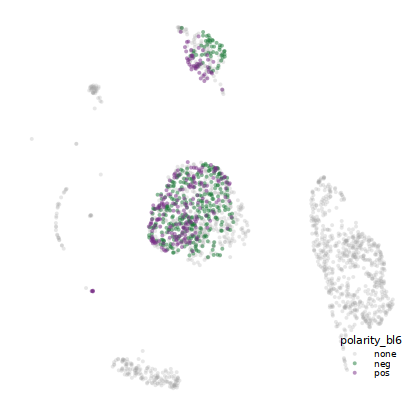

In [18]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

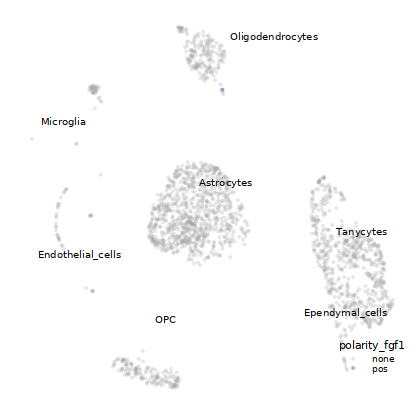

In [19]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

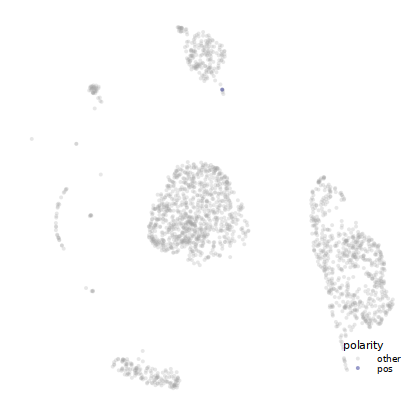

In [20]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [21]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'all.obob14v14__v__all.obobBL6') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
g3,349,7,7,NA,1,0,0,0,0,NaN,0,all.obob14v14__v__all.obobBL6,0.020057307,0.0000000,0.02005731,7
Ghrh,148,2,2,NA,1,105,0,0,0,0.00000000,0,all.obob14v14__v__all.obobBL6,0.013513514,0.7094595,0.72297297,107
Sim1,141,2,NA,2,NA,0,0,0,0,NaN,0,all.obob14v14__v__all.obobBL6,0.014184397,0.0000000,0.01418440,2
Tmem215__Greb1,173,2,2,NA,1,114,2,2,0,0.01754386,1,all.obob14v14__v__all.obobBL6,0.011560694,0.6589595,0.67052023,116
g1,739,2,NA,2,NA,0,0,0,0,NaN,0,all.obob14v14__v__all.obobBL6,0.002706360,0.0000000,0.00270636,2
Oligodendrocytes,197,1,1,NA,1,96,1,1,0,0.01041667,1,all.obob14v14__v__all.obobBL6,0.005076142,0.4873096,0.49238579,97


[1] "g3"                  "Ghrh"                "Sim1"               
 [4] "Tmem215__Greb1"      "g1"                  "Oligodendrocytes"   
 [7] "n2"                  "Agrp"                "Arx__Nr5a2"         
[10] "Astrocytes"          "Dlk1"                "Endothelial_cells"  
[13] "Ependymal_cells"     "Esr1"                "Fez1"               
[16] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[19] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[22] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[25] "Met__Pappa2"         "Met__Prlh"           "Microglia"          
[28] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[31] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[34] "Npsr1__Epha3"        "OPC"                 "Pomc__Anxa2"        
[37] "Pomc__Glipr1"        "Pomc__Ttr"           "Pou6f2__Prkcq__Whrn"
[40] "Ppp1r17"             "Ppp1r17__Ltbp1"      "Ppp1r17__Tafa4"     
[43] "Reln__Lef1"          "Slc17a6__Trhr"       "Sst__Nts"           
[46] "Sst__Pthlh"          "Sst__Unc13c"         "Tanycytes"          
[49] "Tbx19__Pirt"         "Th__Nfib"            "Th__Slc6a3"         
[52] "Tmem215__Dach2"      "Trh__Cxcl12"         "Trh__Lef1"          
[55] "g2"                  "g4"                  "g_drop"             
[58] "n0"                  "n1"                  "n3"                 
[61] "n4"                  "n5"                  "n6"                 
[64] "n8"                  "n_drop"              "neuron"             
[67] "other"

In [22]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,22
other,3
NA,13


In [23]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Agrp,335,0,NA,NA,NA,306,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.913432836,0.913432836,306,neuron
Kiss1__Tac2,213,0,NA,NA,NA,153,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.718309859,0.718309859,153,neuron
Trh__Cxcl12,268,0,NA,NA,NA,147,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.548507463,0.548507463,147,neuron
Tmem215__Greb1,173,2,2,NA,1,114,2,2,0,0.01754386,1,all.obob14v14__v__all.obobBL6,0.01156069,0.658959538,0.670520231,116,neuron
Sst__Unc13c,242,0,NA,NA,NA,112,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.462809917,0.462809917,112,neuron
Ghrh,148,2,2,NA,1,105,0,0,0,0.00000000,0,all.obob14v14__v__all.obobBL6,0.01351351,0.709459459,0.722972973,107,neuron
Htr3b,254,0,NA,NA,NA,93,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.366141732,0.366141732,93,neuron
Pomc__Glipr1,166,0,NA,NA,NA,70,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.421686747,0.421686747,70,neuron
Pomc__Ttr,105,0,NA,NA,NA,59,0,0,0,0.00000000,NaN,all.obob14v14__v__all.obobBL6,0.00000000,0.561904762,0.561904762,59,neuron


In [24]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Dlk1"                "Ependymal_cells"     "Esr1"               
 [4] "Fez1"                "Hdc"                 "Irx5__Lmx1a"        
 [7] "Lepr15"              "Lepr67"              "Lepr89"             
[10] "Microglia"           "Nfib_1"              "Nfib_2"             
[13] "Nfib_3"              "Nfix__Nfib"          "Nfix__Nfib__Hgf"    
[16] "Nfix__Nfib__Lhx6"    "OPC"                 "Pou6f2__Prkcq__Whrn"
[19] "Ppp1r17"             "Ppp1r17__Ltbp1"      "Slc17a6__Trhr"      
[22] "Sst__Nts"            "Sst__Pthlh"          "Tanycytes"          
[25] "Tmem215__Dach2"      "Trh__Lef1"           "g4"                 
[28] "g_drop"              "n8"

In [25]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,148,2,2,NA,1,105,0,0,0,0,0,all.obob14v14__v__all.obobBL6,0.01351351,0.7094595,0.722973,107


In [26]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
55,g3,NA,84,pos_FGF1,no,FGF1,pos.FGF1,0.03041599,1.92108615,g3.FGF1
55,g3,NA,84,pos_FGF1,no,BL6,none,0.41525134,1.53970537,g3.BL6
63,g3,NA,83,pos_FGF1,no,FGF1,pos.FGF1,0.03041599,1.88861120,g3.FGF1
63,g3,NA,83,pos_FGF1,no,BL6,none,0.71693660,1.02733489,g3.BL6
311,g3,NA,59,pos_FGF1,no,FGF1,pos.FGF1,0.03041599,2.03739362,g3.FGF1
311,g3,NA,59,pos_FGF1,no,BL6,none,0.97720572,-0.03185163,g3.BL6
47,g3,NA,84,pos_FGF1,no,FGF1,pos.FGF1,0.03468843,1.83859963,g3.FGF1
47,g3,NA,84,pos_FGF1,no,BL6,none,0.41676270,1.39548075,g3.BL6
62,g3,NA,81,pos_FGF1,no,FGF1,pos.FGF1,0.03468843,1.87009130,g3.FGF1


In [27]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1    55 g3     NA         84 pos_FGF1       no       FGF1       pos.FGF1
2    55 g3     NA         84 pos_FGF1       no       BL6        none    
3    63 g3     NA         83 pos_FGF1       no       FGF1       pos.FGF1
4    63 g3     NA         83 pos_FGF1       no       BL6        none    
5   311 g3     NA         59 pos_FGF1       no       FGF1       pos.FGF1
6   311 g3     NA         59 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [28]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.BL6  pos.BL6  neg.FGF1
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [29]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1]  8 11

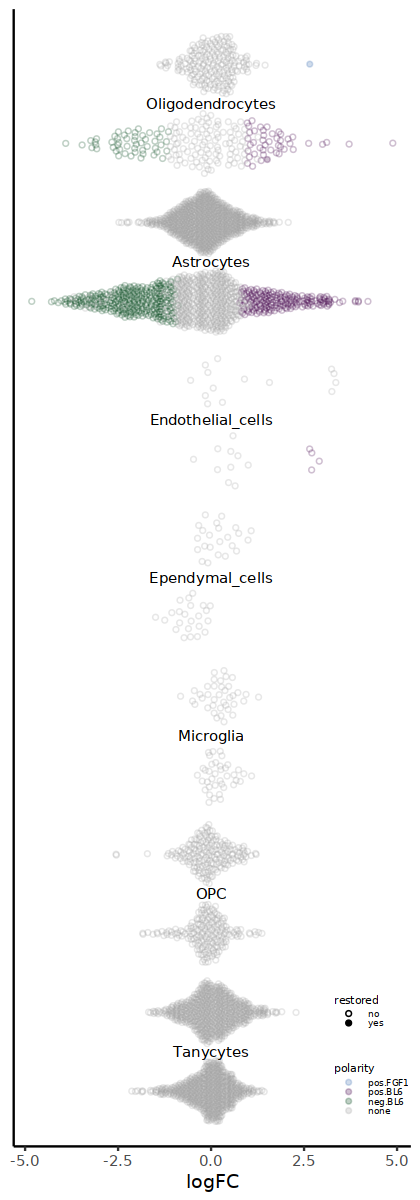

In [30]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

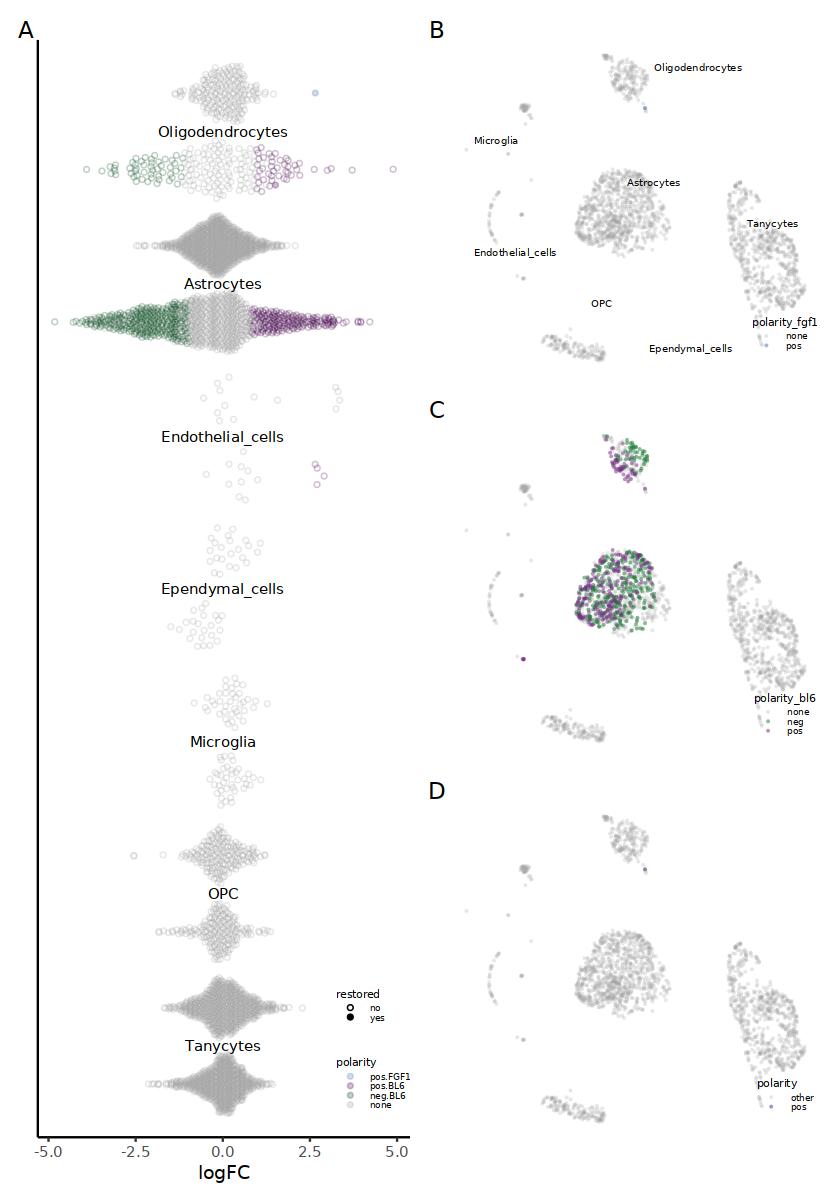

In [31]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_all_d14_vehall.pdf', plot = ., width = 7, height=9)
ggp

In [32]:
unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
# filter(n == 1) %>%
pull(labels)

unchanged_labels_bl6

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] "Agrp"                "Arx__Nr5a2"          "Astrocytes"         
 [4] "Dlk1"                "Endothelial_cells"   "Ependymal_cells"    
 [7] "Esr1"                "Fez1"                "Ghrh"               
[10] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[13] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[16] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[19] "Met__Pappa2"         "Met__Prlh"           "Microglia"          
[22] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[25] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[28] "Npsr1__Epha3"        "OPC"                 "Oligodendrocytes"   
[31] "Pomc__Anxa2"         "Pomc__Glipr1"        "Pomc__Ttr"          
[34] "Pou6f2__Prkcq__Whrn" "Ppp1r17"             "Ppp1r17__Ltbp1"     
[37] "Ppp1r17__Tafa4"      "Reln__Lef1"          "Sim1"               
[40] "Slc17a6__Trhr"       "Sst__Nts"            "Sst__Pthlh"         
[43] "Sst__Unc13c"         "Tanycytes"           "Tbx19__Pirt"        
[46] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[49] "Tmem215__Greb1"      "Trh__Cxcl12"         "Trh__Lef1"          
[52] "g1"                  "g2"                  "g3"                 
[55] "g4"                  "g_drop"              "n0"                 
[58] "n1"                  "n2"                  "n3"                 
[61] "n4"                  "n5"                  "n6"                 
[64] "n8"                  "n_drop"              "neuron"             
[67] "other"

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 32

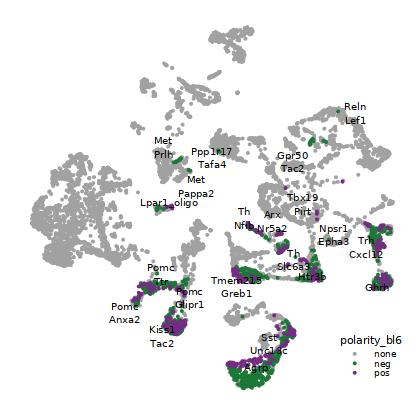

In [33]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 1, "neg" = 1, "pos"=1)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 60

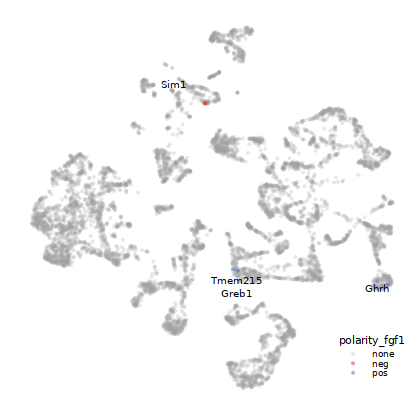

In [34]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

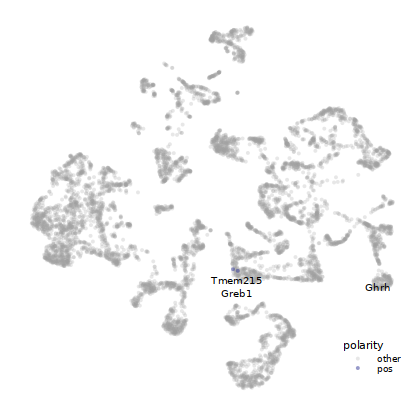

In [35]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

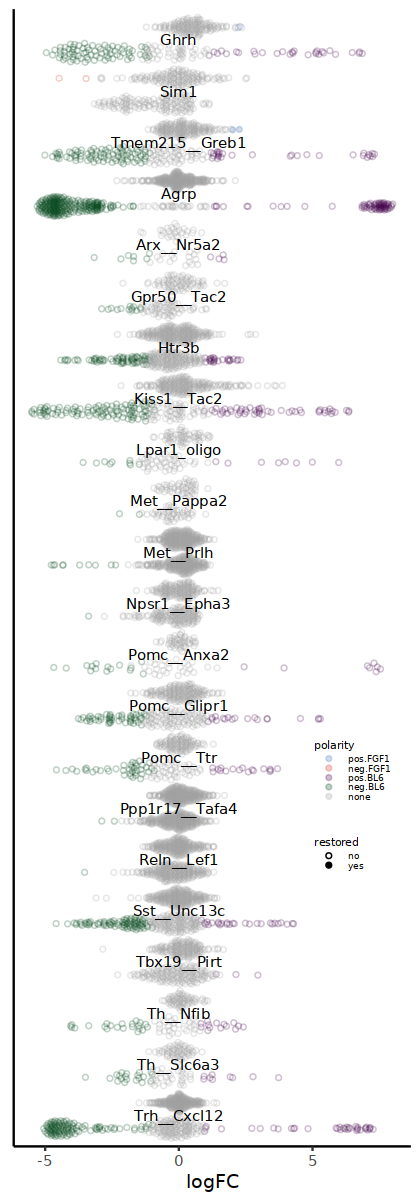

In [36]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

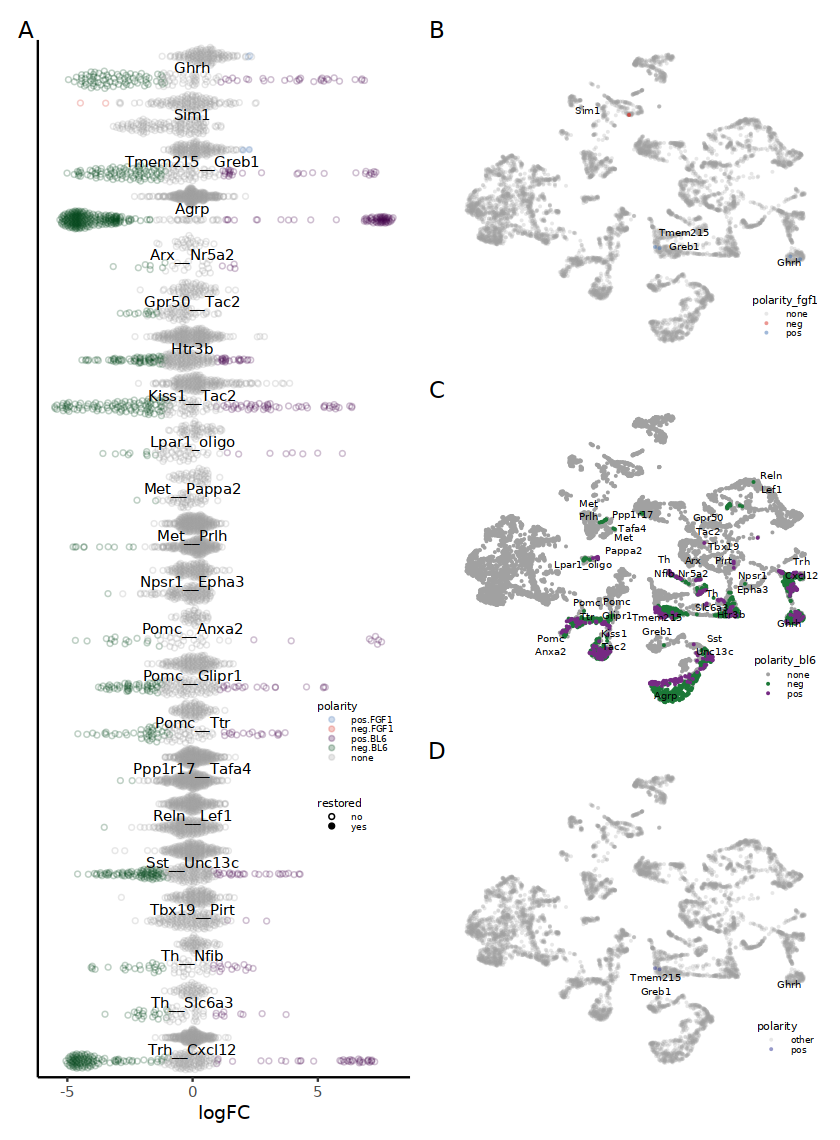

In [37]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_all_d14_vehall.pdf', plot = ., width = 7, height=9)
ggp

In [38]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_.qs')
da_results %>% qs::qsave('beeswarm_da_results_.qs')